<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [1]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

In [88]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

## Задание 1 (1 балл). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекомендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [89]:
# скачаем данные
!wget 'https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/met-office-weather-month.csv'
!wget 'https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/DailyDelhiClimateTest.csv'
!wget 'https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/DailyDelhiClimateTrain.csv'

--2022-04-19 14:37:24--  https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/met-office-weather-month.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124682 (122K) [text/plain]
Saving to: ‘met-office-weather-month.csv.2’

met-office-weather- 100%[===================>] 121.76K  --.-KB/s    in 0.02s   

2022-04-19 14:37:24 (5.76 MB/s) - ‘met-office-weather-month.csv.2’ saved [124682/124682]

--2022-04-19 14:37:24--  https://raw.githubusercontent.com/Dima-Kalmykov/iad-applied-ds/master/2022/hw/DailyDelhiClimateTest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... co

In [90]:
# считаем файлы
ts1 = pd.read_csv("met-office-weather-month.csv")[:502]
ts2_test = pd.read_csv("DailyDelhiClimateTest.csv")
ts2_train =  pd.read_csv("DailyDelhiClimateTrain.csv")

In [91]:
def create_date(row):
    new_month_value = str(row.month)
    if row.month < 10:
      new_month_value = f'0{row.month}'
    
    date = str(row.year) + '-' + new_month_value

    return pd.to_datetime(date)

ts1['date'] = ts1.apply(create_date, axis=1)
first_column = ts1.pop('date')  
ts1.insert(0, 'date', first_column)
ts1 = ts1[['date', 'rain']]
ts1 = ts1[ts1['rain'].notna()]
ts1.head()

,date,rain
0,1978-09-01,26.7
1,1978-10-01,20.4
2,1978-11-01,56.3
3,1978-12-01,276.7
4,1979-01-01,134.8


In [92]:
ts2_train['date'] = pd.to_datetime(ts2_train['date'])
ts2_test['date'] = pd.to_datetime(ts2_test['date'])

In [93]:
ts1.tail()

,date,rain
497,2020-02-01,176.0
498,2020-03-01,75.8
499,2020-04-01,40.0
500,2020-05-01,28.8
501,2020-06-01,117.0


In [94]:
test_share = len(ts2_test) / (len(ts2_test) + len(ts2_train))

threshold = int(len(ts1) * (1 - test_share))
ts1_train = ts1[:threshold]
ts1_test = ts1[threshold:]

print(len(ts1_train), len(ts1_test))

465 37


In [95]:
ts2_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [96]:
ts2_train = ts2_train[['date', 'meantemp']]
ts2_test = ts2_test[['date', 'meantemp']]

print(len(ts2_train), len(ts2_test))

1462 114


## Задание 2. Анализ временных рядов (1 балл).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики [автокорреляционных функций](https://www.machinelearningmastery.ru/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788/) для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

In [97]:
# отрисуем временные ряды
# plt.figure(figsize=(12, 4))
# plt.plot(..., ...)
# plt.xlabel('Time')
# plt.show()

In [98]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')

In [99]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

## Задание 3. Предсказание месячного временного ряда (4 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной ряд несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.

### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [100]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error as mae

forecasting_horizon = ForecastingHorizon(ts1_test.index, is_relative=False)

In [101]:
test_rain = ts1_test['rain']
train_rain = ts1_train['rain']

In [102]:
def make_plot(predicted_data):
    plt.plot(test_rain)
    plt.plot(predicted_data)
    plt.legend(['Actual', 'Predicted']);

In [103]:
native_forecaster = NaiveForecaster(strategy="last")
native_forecaster.fit(train_rain)

NaiveForecaster()

In [104]:
ts1_predicted = native_forecaster.predict(forecasting_horizon)
mae(test_rain, ts1_predicted)

57.45405405405405

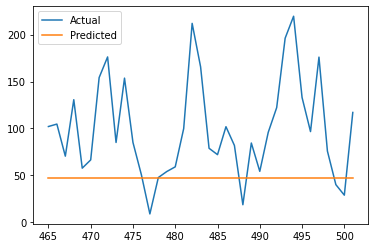

In [105]:
make_plot(ts1_predicted)

In [106]:
native_forecaster_season = NaiveForecaster(strategy="last", sp = 12)
native_forecaster_season.fit(train_rain)

NaiveForecaster(sp=12)

In [107]:
ts1_predicted_season = native_forecaster_season.predict(forecasting_horizon)
mae(test_rain, ts1_predicted_season)

47.94864864864865

In [108]:
ts1_predicted_season.head()

465     65.8
466     23.2
467     57.4
468    153.7
469     53.2
dtype: float64

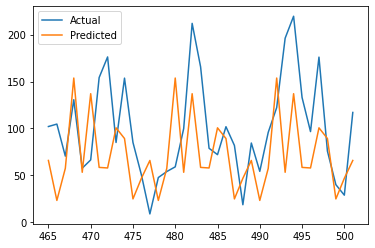

In [109]:
make_plot(ts1_predicted_season)

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [110]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

arima = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12))
arima.fit(train_rain)

ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12))

In [111]:
ts1_predicted_arima = arima.predict(forecasting_horizon)
mae(test_rain, ts1_predicted_arima)

62.18719007063791

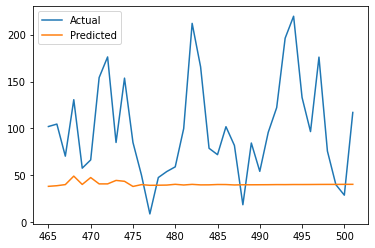

In [112]:
make_plot(ts1_predicted_arima)

In [113]:
auto_arima = AutoARIMA(sp=12)
auto_arima.fit(test_rain)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-inver

AutoARIMA(sp=12)

In [114]:
ts1_pred_auto_arima = auto_arima.predict(forecasting_horizon)
mae(test_rain, ts1_pred_auto_arima)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


37.36994811237119

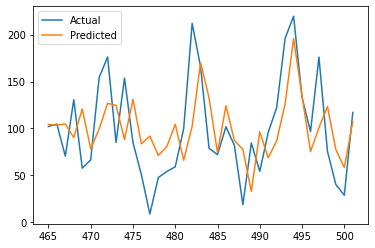

In [115]:
make_plot(ts1_pred_auto_arima)

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [116]:
from orbit.models import LGT
from orbit.models import DLT

dlt = DLT(
    response_col='rain', 
    date_col='date',
    seasonality=12,
)

dlt.fit(ts1_train)
ts1_predicted_dlt = dlt.predict(ts1_test)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05ff738ef22ce2e8a332ce639cee65cf NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [119]:
from orbit.diagnostics.plot import plot_predicted_data

def make_predicted_plot(predicted_data, model_type):
    plot_predicted_data(
      training_actual_df=ts1_train,
      test_actual_df=ts1_test,
      predicted_df=predicted_data,
      actual_col=dlt.response_col,
      date_col=dlt.date_col,
      title=f'{model_type} model result'
    )

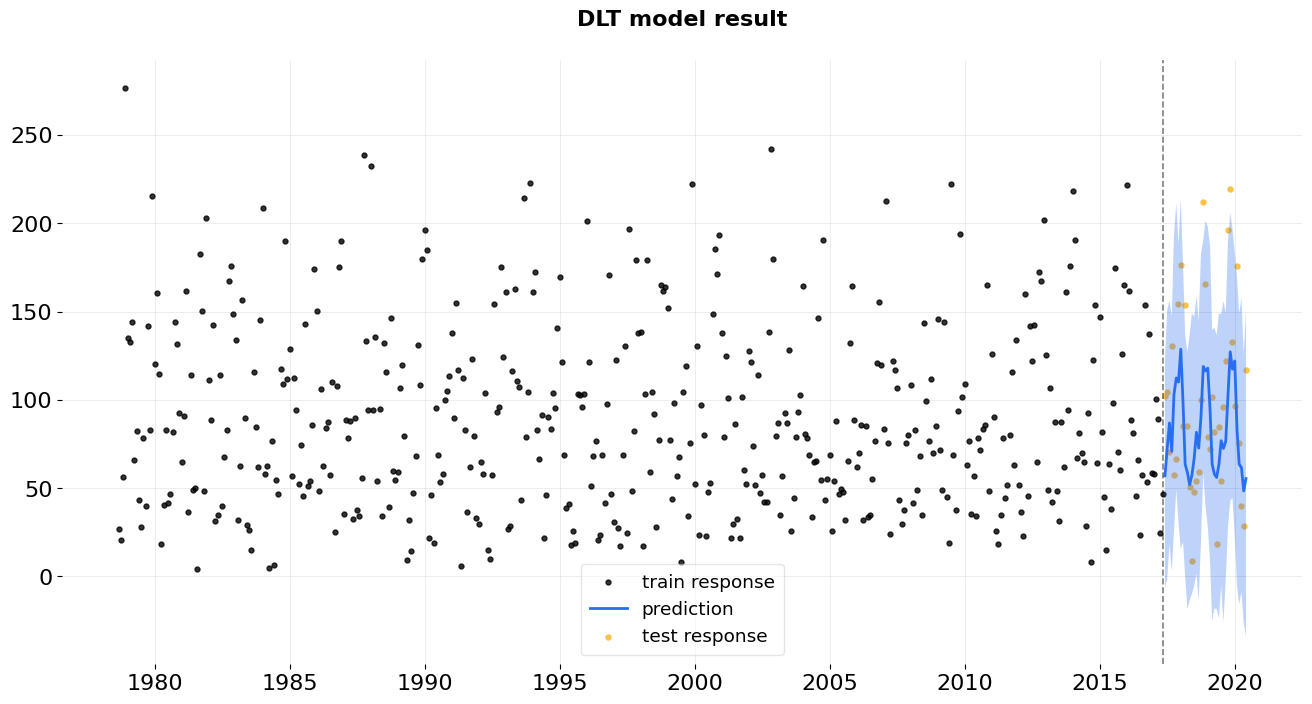

In [120]:
make_predicted_plot(ts1_predicted_dlt, "DLT")

In [121]:
mae(test_rain, ts1_predicted_dlt['prediction'])

38.869929316116625

In [122]:
lgt = LGT(
    response_col='rain', 
    date_col='date',
    seasonality=12,
)

lgt.fit(ts1_train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d372bb7bc77e1df83218127fc9dd707d NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [123]:
ts1_predicted_lgt = lgt.predict(ts1_test)

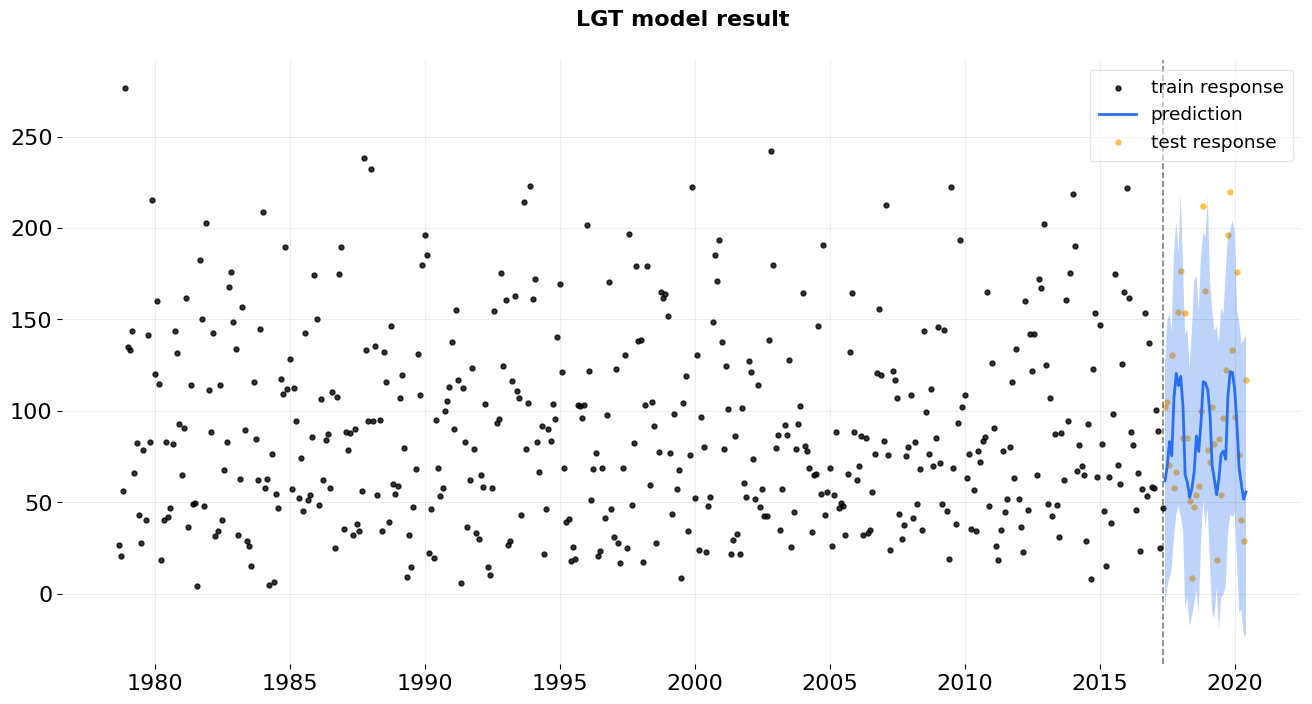

In [124]:
make_predicted_plot(ts1_predicted_lgt, "LGT")

In [ ]:
mae(test_rain, ts1_predicted_lgt['prediction'])

### ETS (1 балл).

Обучите из библиотеки `sktime` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [125]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

exponential_smoothing = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
exponential_smoothing.fit(train_rain)

ExponentialSmoothing(seasonal='multiplicative', sp=12, trend='add')

In [126]:
ts1_predicted_smoothing = exponential_smoothing.predict(forecasting_horizon)
mae(test_rain, ts1_predicted_smoothing)

38.75084885327607

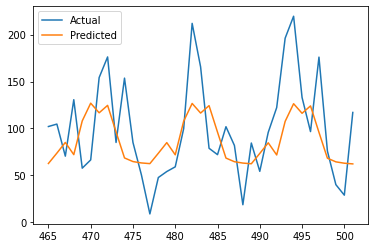

In [127]:
make_plot(ts1_predicted_smoothing)

In [128]:
auto_ets = AutoETS(auto=True, sp=12)
auto_ets.fit(train_rain)

AutoETS(auto=True, sp=12)

In [129]:
ts1_predicted_auto_ets = auto_ets.predict(forecasting_horizon)
mae(test_rain, ts1_predicted_auto_ets)

36.75162412349777

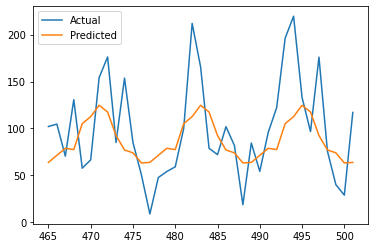

In [130]:
make_plot(ts1_predicted_auto_ets)

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [ ]:
# нарисуйте пресказания

## Задание 4. Предсказание дневного временного ряда (3 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

### Phophet (1 балл).



In [ ]:
from prophet import Prophet

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [ ]:
# нарисуйте пресказания

## Задание 5. Предсказание временного ряда моделями машинного обучения (1 балл).

Возьмите один из ваших рядов, сформируйте по нему матрицу объект-признак и целевой вектор.

Разбейте данные на train/test в той же пропорции, что разбивали в заданиях выше.

Обучите различные классические модели машинного обучения и оцените их качество (MAE). 

Какая из моделей справилась с задачей предсказания лучше всего?

In [ ]:
# обучите классические модели ML

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытайте свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной моделью на тестовой выборке с помощью MAE. 

Комментарий: итоговый балл за домашнее задание ставится по формуле минимум(10, ваш суммарный балл за задания).

In [ ]:
# ваш код модели на STAN и её обучения здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте предсказания